In [1]:
import sys
sys.path.append('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/codes/')
from module.backtesting_old import vectorized_backtesting
from numpy import linalg as LA
import pandas as pd
import numpy as np

# TBN bias test

In [27]:
def get_mse_of_matrix(y: np.ndarray, y_hat: np.ndarray) -> np.float_:
    matrix_square = np.square(y - y_hat)
    matrix_mean_square = np.average(matrix_square)

    return matrix_mean_square

In [28]:
# get tbn and correlation matrix
backtest_agent = vectorized_backtesting()
tbn_total = backtest_agent.tbn_combined
correlation_matrix_total = backtest_agent.correlation_aggregate

# use whole sample average as y turth
tbn_sample_average = tbn_total.groupby(level=1).mean()
correlation_sample_average = correlation_matrix_total.groupby(level=1).mean()

# get bias for tbn and correlation matrix
year_start = 1996
year_end = 2017
year_range = np.arange(year_start, year_end + 1)
bias_correlation = [get_mse_of_matrix(correlation_matrix_total.loc[year], correlation_sample_average) for year in year_range]
bias_tbn = [get_mse_of_matrix(tbn_total.loc[year], tbn_sample_average) for year in year_range]

# store in data frame
bias_dict = {'Sample correlation': bias_correlation, 'TBN': bias_tbn}
bias_df = pd.DataFrame(bias_dict)
bias_df = bias_df.set_index(year_range)

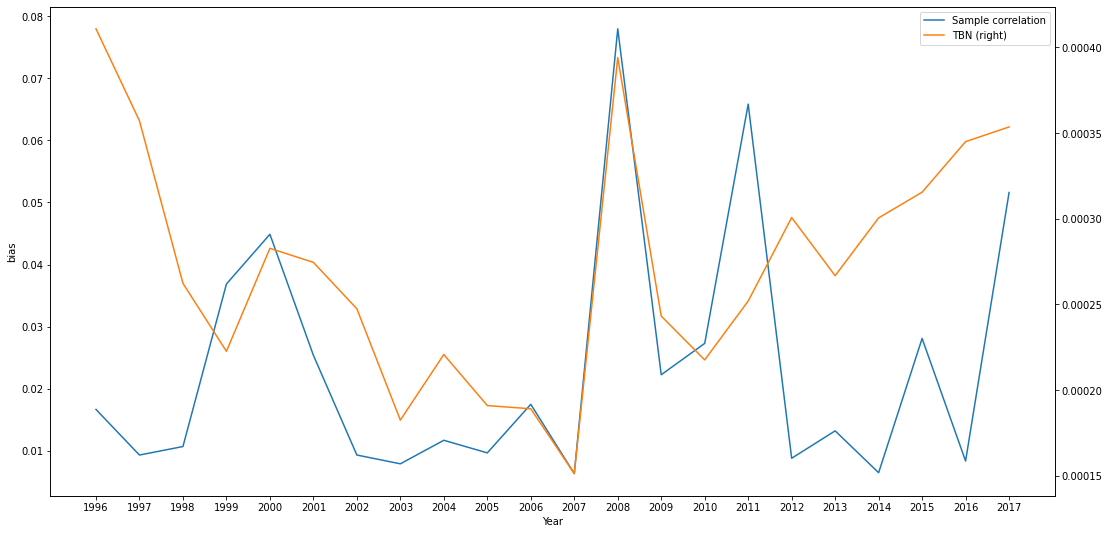

In [85]:
ax = bias_df.plot(y = 'Sample correlation',
            xlabel = 'Year',
            ylabel = 'bias',
            figsize = (18, 9),
            xticks = range(1996, 2018),
            rot = 45)
ax2 = bias_df.plot(y = 'TBN', secondary_y=True, ax=ax)


In [87]:
output_path = '/Users/cheng/Dropbox/Apps/Overleaf/Portfolio Selection via Text Based Network/picture/'
file_name = 'Bias of TBN and Sample Correlation Matrix'
file_type = '.png'
ax2.figure.tight_layout()
ax2.figure.savefig(output_path + file_name + file_type)

The bias of an estimator is defined as 
$$bias(\hat{\Sigma}, \Sigma) = ||E\hat{\Sigma} - \Sigma||^2$$
Where the estimator $\hat{\Sigma}$ is the shrinkage target, which is either TBN or identity matrix

In [2]:
bt = vectorized_backtesting()
year_start = 1996
year_end = 2017

In [3]:
# sample correlation
stock_return_sample = bt.stocks_returns_aggregate.loc[year_start: year_end]
correlation_matrix_sample = stock_return_sample.corr()

In [4]:
# tbn as estimator
tbn = bt.tbn_combined
tbn_mean = tbn.groupby(level=1).mean()
tbn_mean.columns = [bt.company_key.inverse[int(gvkey)] for gvkey in tbn_mean.columns]
tbn_mean.index = [bt.company_key.inverse[int(gvkey)] for gvkey in tbn_mean.index]

In [5]:
# bias for both TBN and identity matrix
bias_tbn = np.sqrt(LA.norm(tbn_mean - correlation_matrix_sample, 2))
bias_identity = np.sqrt(LA.norm(np.eye(len(correlation_matrix_sample)) - correlation_matrix_sample, 2))

In [6]:
# stor data
bias_df = pd.DataFrame()
bias_df['TBN'] = [bias_tbn]
bias_df['Identity matrix'] = [bias_identity]
bias_df.index = ['bias']

In [7]:
# output to DB
from module.data_handler import data_handler
dh = data_handler()
table_name = 'Bias of TBN and Sample Correlation Matrix'
label = 'tbl:bias_tbn_id'
caption = 'This table reports the bias of TBN and identity matrix. The considering data set is Dow 30 stocks from 1996 to 2017. \
           While both TBN and indentity matrix, serving as shrinking target, have bias toward the true covarianve matrix. \
           TBN has smaller bias than identity matrix.'
dh.export_dataframe_to_latex_table(df = bias_df,
                                   table_name='Bias of TBN and Sample Correlation Matrix',
                                   caption=caption,
                                   label=label)